In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# 1. Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = '/content/drive/MyDrive/Dataset/Cars Dataset'  # ganti sesuai path-mu

# 2. Transformasi
transform = {
    'train': transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
    ])
}

# 3. Dataset dan DataLoader
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform['train'])
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform['test'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
num_classes = len(class_names)

# 4. Load InceptionV3
model = models.inception_v3(pretrained=True, aux_logits=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)
model = model.to(device)

# 5. Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 6. Training
epochs = 10
model.train()

for epoch in range(epochs):
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        outputs, aux_outputs = model(images)
        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels)
        loss = loss1 + 0.4 * loss2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    acc = 100. * correct / total
    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | Train Acc: {acc:.2f}%")

# 7. Testing
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100. * correct / total
print(f"\n🎯 Final Test Accuracy: {test_acc:.2f}%")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 105/105 [21:13<00:00, 12.13s/it]


Epoch 1 | Loss: 92.0249 | Train Acc: 80.31%


Epoch 2/10: 100%|██████████| 105/105 [01:04<00:00,  1.62it/s]


Epoch 2 | Loss: 11.7579 | Train Acc: 98.12%


Epoch 3/10: 100%|██████████| 105/105 [01:04<00:00,  1.62it/s]


Epoch 3 | Loss: 3.9209 | Train Acc: 99.46%


Epoch 4/10: 100%|██████████| 105/105 [01:04<00:00,  1.62it/s]


Epoch 4 | Loss: 3.3376 | Train Acc: 99.26%


Epoch 5/10: 100%|██████████| 105/105 [01:04<00:00,  1.62it/s]


Epoch 5 | Loss: 2.6207 | Train Acc: 99.64%


Epoch 6/10: 100%|██████████| 105/105 [01:04<00:00,  1.62it/s]


Epoch 6 | Loss: 3.1539 | Train Acc: 99.43%


Epoch 7/10: 100%|██████████| 105/105 [01:05<00:00,  1.59it/s]


Epoch 7 | Loss: 1.9658 | Train Acc: 99.70%


Epoch 8/10: 100%|██████████| 105/105 [01:04<00:00,  1.62it/s]


Epoch 8 | Loss: 1.8586 | Train Acc: 99.73%


Epoch 9/10: 100%|██████████| 105/105 [01:04<00:00,  1.63it/s]


Epoch 9 | Loss: 1.2525 | Train Acc: 99.73%


Epoch 10/10: 100%|██████████| 105/105 [01:05<00:00,  1.61it/s]


Epoch 10 | Loss: 1.6495 | Train Acc: 99.70%

🎯 Final Test Accuracy: 98.65%


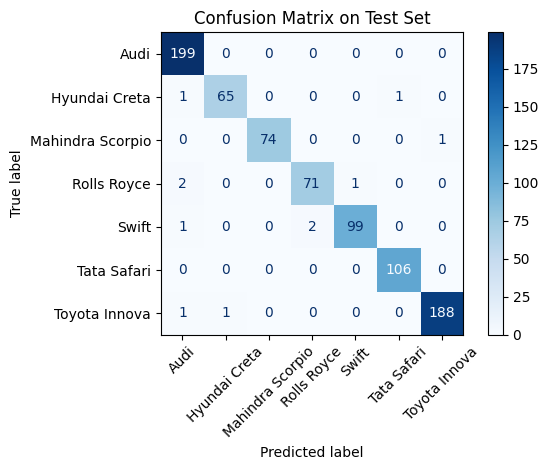

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

In [6]:
model_save_path = '/content/drive/MyDrive/Dataset/Cars Dataset/trained_inceptionv3_cars.pth' # ganti sesuai path-mu
torch.save(model.state_dict(), model_save_path)
print(f"\n✅ Model saved to {model_save_path}")


✅ Model saved to /content/drive/MyDrive/Dataset/Cars Dataset/trained_inceptionv3_cars.pth


# **Evaluation**

In [13]:
import torch
import numpy as np

def evaluate_model(model, test_loader, class_names, device):
    model.eval()
    correct = 0
    total = 0

    # Untuk per kelas
    class_correct = [0 for _ in range(len(class_names))]
    class_total = [0 for _ in range(len(class_names))]

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            for i in range(len(labels)):
                label = labels[i]
                pred = predicted[i]
                class_total[label] += 1
                if pred == label:
                    class_correct[label] += 1

    # Akurasi total
    total_acc = 100. * correct / total
    print(f"\n🎯 Overall Accuracy on Test Set: {total_acc:.2f}%\n")

    # Akurasi per kelas
    for i in range(len(class_names)):
        if class_total[i] > 0:
            acc = 100. * class_correct[i] / class_total[i]
            print(f"Class: {class_names[i]:<20} | Accuracy: {acc:.2f}% ({class_correct[i]}/{class_total[i]})")
        else:
            print(f"Class: {class_names[i]:<20} | No samples")

    return total_acc

In [14]:
class_names = train_dataset.classes

# Jalankan evaluasi
evaluate_model(model, test_loader, class_names, device)


🎯 Overall Accuracy on Test Set: 98.65%

Class: Audi                 | Accuracy: 100.00% (199/199)
Class: Hyundai Creta        | Accuracy: 97.01% (65/67)
Class: Mahindra Scorpio     | Accuracy: 98.67% (74/75)
Class: Rolls Royce          | Accuracy: 95.95% (71/74)
Class: Swift                | Accuracy: 97.06% (99/102)
Class: Tata Safari          | Accuracy: 100.00% (106/106)
Class: Toyota Innova        | Accuracy: 98.95% (188/190)


98.6469864698647

In [25]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os

def predict_and_show(image_path, model, class_names, device, true_label=None):
    # Transformasi sesuai input model
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
    ])

    # Load dan transform gambar
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Prediksi
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        confidence, pred_idx = torch.max(probs, 1)
        pred_class = class_names[pred_idx.item()]
        confidence = confidence.item() * 100

    # Penilaian kebenaran
    if true_label is not None:
        is_correct = (pred_class.lower() == true_label.lower())
        status = "(Benar)" if is_correct else "(Salah)"
        label_info = f"Predicted: {pred_class} ({confidence:.2f}%)\nActual: {true_label} {status}"
    else:
        label_info = f"Predicted: {pred_class} ({confidence:.2f}%)"

    # Tampilkan gambar + hasil
    plt.imshow(image)
    plt.title(label_info)
    plt.axis('off')
    plt.show()

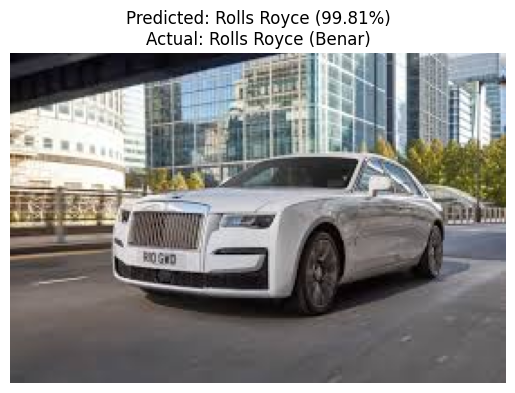

In [26]:
image_path = "/content/drive/MyDrive/Dataset/Cars Dataset/test/Rolls Royce/101.jpg"  # contoh path gambar
predict_and_show(image_path, model, class_names, device, true_label="Rolls Royce")